# Install the required packages

In [ ]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install scikit-learn
%pip install imbalanced-learn

# Download the dataset and load datas

In [1]:
import os
import kagglehub

path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")
file_path1 = os.path.join(path, "yellow_tripdata_2015-01.csv")  # Path to the dataset file
file_path2 = os.path.join(path, "yellow_tripdata_2016-01.csv")  # Path to the dataset file
file_path3 = os.path.join(path, "yellow_tripdata_2016-02.csv")  # Path to the dataset file
file_path4 = os.path.join(path, "yellow_tripdata_2016-03.csv")  # Path to the dataset file

In [2]:
# Verifica degli attributi presenti
import pandas as pd
df_sample = pd.read_csv(file_path1, nrows=5)
print(df_sample.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


# Load only the needed columns

In [3]:
import pandas as pd

needed_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tip_amount",            # Importo della mancia
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
    "tpep_pickup_datetime",  # Data e ora di inizio del viaggio
    # "tpep_dropoff_datetime", # Data e ora di fine del viaggio (forse inutile)
    # "pickup_longitude",      # Longitudine del punto di partenza (forse inutile)
    # "pickup_latitude",       # Latitudine del punto di partenza (forse inutile)
    # "dropoff_longitude",     # Longitudine del punto di arrivo (forse inutile)
    # "dropoff_latitude",      # Latitudine del punto di arrivo (forse inutile)
    "payment_type"           # Tipo di pagamento (target)
]

df_2015_01 = pd.read_csv(file_path1, usecols=needed_columns)    # Load the dataset  in a DataFrame
df_2016_01 = pd.read_csv(file_path2, usecols=needed_columns)    # Load the dataset  in a DataFrame
df_2016_02 = pd.read_csv(file_path3, usecols=needed_columns)    # Load the dataset  in a DataFrame
df_2016_03 = pd.read_csv(file_path4, usecols=needed_columns)    # Load the dataset  in a DataFrame

# Join the different dataframes

In [4]:
df = pd.concat([df_2015_01, df_2016_01, df_2016_02, df_2016_03], ignore_index=True)
print (df.columns)

Index(['tpep_pickup_datetime', 'passenger_count', 'trip_distance',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount'],
      dtype='object')


# Transformation: managing null values (if exist)

In [5]:
def check_null_values(df):
    if df.isnull().values.any():
        print("Il DataFrame contiene valori nulli.")
        # Mostra le colonne con valori nulli e il conteggio di tali valori
        null_columns = df.isnull().sum()
        print("Colonne con valori nulli:")
        print(null_columns[null_columns > 0])
    else:
        print("Non ci sono valori nulli nel DataFrame.")
        
check_null_values(df)

Il DataFrame contiene valori nulli.
Colonne con valori nulli:
improvement_surcharge    3
dtype: int64


In [6]:
# Dato che i valori nulli sono pochi, possiamo eliminare i record contenenti i valori nulli
num_rows_before = df.shape[0]
print(num_rows_before)
df_cleaned = df.dropna()
num_rows_after = df_cleaned.shape[0]
print(num_rows_after)

47248845
47248842


# Verifying the balance of the dataset

In [7]:
# Conta le occorrenze di ciascun codice di pagamento
payment_type_counts = df_cleaned['payment_type'].value_counts()

# Stampa i risultati
print("Conteggio delle righe per ciascun codice di pagamento:")
print(payment_type_counts)

# No charge payment significa che il passeggero non è stato addebitato per il viaggio.
# Dispute payment indica che il pagamento è stato contestato dal cliente.
# Non essendo rilevanti ai fini dell'analisi, abbiamo deciso di eliminare le righe che presentano payment type pari a 3, 4, 5

# Elimina le righe con valori 3, 4, o 5 nella colonna 'payment_type'
df_filtered = df_cleaned[~df_cleaned['payment_type'].isin([3, 4, 5])]
print("Nuovo numero di righe: ")
print(df_filtered.shape[0])

Conteggio delle righe per ciascun codice di pagamento:
payment_type
1    30870611
2    16158086
3      164138
4       56004
5           3
Name: count, dtype: int64
Nuovo numero di righe: 
47028697


# Transformation: normalizing the values

In [8]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tip_amount",            # Importo della mancia
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
]

def normalize_numeric_columns(df, numeric_columns):
    # Inizializza lo scaler per la normalizzazione
    scaler = MinMaxScaler()
    # Normalizza solo le colonne numeriche
    df.loc[:, numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

# Normalizzazione delle colonne numeriche
df_normalized = normalize_numeric_columns(df_filtered, numeric_columns)
# print(df_normalized)
print(df_normalized.columns)

# Seleziona solo le colonne specificate in numeric_columns
numeric_df_normalized = df_normalized[numeric_columns]
# print (numeric_df_normalized)
print(numeric_df_normalized.columns)

/var/folders/cw/r79hxm697kv7jz3npd6fb6l80000gn/T/ipykernel_3958/3935103675.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.11111111 0.11111111 0.11111111 ... 0.11111111 0.11111111 0.11111111]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, numeric_columns] = scaler.fit_transform(df[numeric_columns])


Index(['tpep_pickup_datetime', 'passenger_count', 'trip_distance',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount'],
      dtype='object')
Index(['trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'improvement_surcharge', 'tip_amount', 'tolls_amount', 'total_amount',
       'passenger_count'],
      dtype='object')


# Using get_dummies() for tpep_pickup_datetime and payment_type features

In [9]:
# A seconda del momento della giornata in cui inizia la corsa, il prezzo totale può cambiare
def get_period(hour):
    if 6 <= hour < 18:
        return 'giorno'
    else:
        return 'notte'

# Converti le colonne in formato datetime
df_normalized['tpep_pickup_datetime'] = pd.to_datetime(df_normalized['tpep_pickup_datetime'])
# Crea una nuova colonna "pickup_period" per indicare giorno o notte
df_normalized['pickup_period'] = df_normalized['tpep_pickup_datetime'].dt.hour.apply(get_period)
print(df_normalized)

/var/folders/cw/r79hxm697kv7jz3npd6fb6l80000gn/T/ipykernel_3958/1009854752.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['tpep_pickup_datetime'] = pd.to_datetime(df_normalized['tpep_pickup_datetime'])


         tpep_pickup_datetime  passenger_count  trip_distance  payment_type  \
0         2015-01-15 19:05:39         0.111111       0.150939             1   
1         2015-01-10 20:33:38         0.111111       0.150940             1   
2         2015-01-10 20:33:38         0.111111       0.150939             2   
3         2015-01-10 20:33:39         0.111111       0.150939             2   
4         2015-01-10 20:33:39         0.111111       0.150940             2   
...                       ...              ...            ...           ...   
47248840  2016-03-31 16:34:36         0.111111       0.150939             2   
47248841  2016-03-26 03:02:32         0.111111       0.150939             1   
47248842  2016-03-20 08:43:59         0.111111       0.150940             1   
47248843  2016-03-20 08:49:47         0.111111       0.150940             1   
47248844  2016-03-20 08:50:24         0.111111       0.150940             1   

          fare_amount     extra   mta_tax  tip_amou

/var/folders/cw/r79hxm697kv7jz3npd6fb6l80000gn/T/ipykernel_3958/1009854752.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['pickup_period'] = df_normalized['tpep_pickup_datetime'].dt.hour.apply(get_period)


In [10]:
# Usa get_dummies per trasformare la colonna pickup_period in one-hot encode
# 1 è notte, 0 è giorno

# Applica get_dummies per trasformare la colonna pickup_period in variabili dummy
df_normalized = pd.get_dummies(df_normalized, columns=['pickup_period'], drop_first=True)

# Converte pickup_period_notte da booleano a intero (1 per True (carta di credito), 0 per False)
df_normalized['pickup_period_notte'] = df_normalized['pickup_period_notte'].astype(int)
# Crea una colonna binaria 'payment_type_creditCard' che è 1 se 'payment_type' è 1, altrimenti 0
df_normalized['payment_type_creditCard'] = (df_normalized['payment_type'] == 1).astype(int)

print(df_normalized)


         tpep_pickup_datetime  passenger_count  trip_distance  payment_type  \
0         2015-01-15 19:05:39         0.111111       0.150939             1   
1         2015-01-10 20:33:38         0.111111       0.150940             1   
2         2015-01-10 20:33:38         0.111111       0.150939             2   
3         2015-01-10 20:33:39         0.111111       0.150939             2   
4         2015-01-10 20:33:39         0.111111       0.150940             2   
...                       ...              ...            ...           ...   
47248840  2016-03-31 16:34:36         0.111111       0.150939             2   
47248841  2016-03-26 03:02:32         0.111111       0.150939             1   
47248842  2016-03-20 08:43:59         0.111111       0.150940             1   
47248843  2016-03-20 08:49:47         0.111111       0.150940             1   
47248844  2016-03-20 08:50:24         0.111111       0.150940             1   

          fare_amount     extra   mta_tax  tip_amou

# Feature Correlation

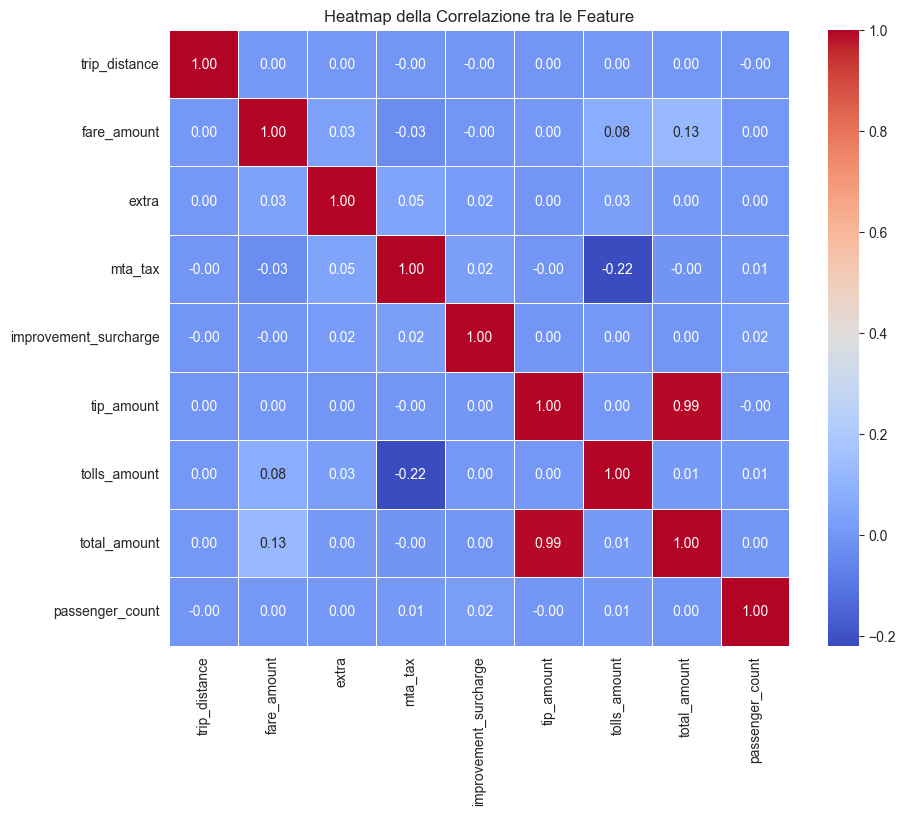

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di correlazione (tiene in considerazione solo gli attributi numerici)
correlation_matrix = numeric_df_normalized.corr()

# Imposta la dimensione della figura
plt.figure(figsize=(10, 8))

# Crea la heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Aggiungi titolo e mostra la heatmap
plt.title("Heatmap della Correlazione tra le Feature")
plt.show()

# Deleting the features highly correlated

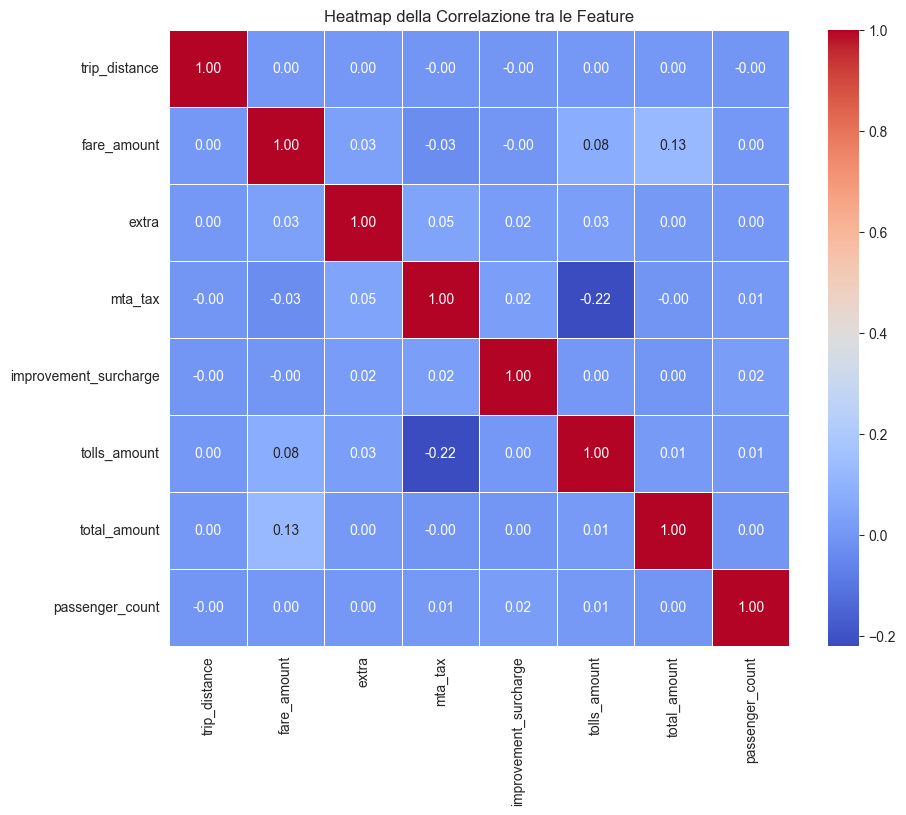

In [12]:
# Eliminazione di tip_amount dalla colonne da tenere in considerazione
# In quanto la feature genera due alti livelli di correlazione

new_numeric_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
]

new_numeric_df_normalized = numeric_df_normalized[new_numeric_columns]

# Calcola la matrice di correlazione
correlation_matrix = new_numeric_df_normalized.corr()

# Imposta la dimensione della figura
plt.figure(figsize=(10, 8))

# Crea la heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Aggiungi titolo e mostra la heatmap
plt.title("Heatmap della Correlazione tra le Feature")
plt.show()

In [13]:
final_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
    "payment_type_creditCard", # Tipo di pagamento
    "pickup_period_notte", # Inizio della corsa
]

# Mantieni solo le colonne specificate in final_columns
df_normalized = df_normalized[final_columns]
print (df_normalized)

          trip_distance  fare_amount     extra   mta_tax  \
0              0.150939     0.001075  0.074143  0.016538   
1              0.150940     0.001080  0.073680  0.016538   
2              0.150939     0.001069  0.073680  0.016538   
3              0.150939     0.001055  0.073680  0.016538   
4              0.150940     0.001082  0.073680  0.016538   
...                 ...          ...       ...       ...   
47248840       0.150939     0.001091  0.074143  0.016538   
47248841       0.150939     0.001056  0.074143  0.016538   
47248842       0.150940     0.001168  0.073217  0.016538   
47248843       0.150940     0.001145  0.074143  0.016538   
47248844       0.150940     0.001168  0.073217  0.016538   

          improvement_surcharge  tolls_amount  total_amount  passenger_count  \
0                           1.0      0.008546      0.000118         0.111111   
1                           1.0      0.008546      0.000118         0.111111   
2                           1.0      0.

# Balancing and reducing the dataset

In [33]:
# Dato che esistono molti più casi in cui viene utilizzata la carta di credito come metodo di pagamento,
# applichiamo undersampling

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Separiamo le feature (X) dal target (y)
# payment_type_creditCard rappresenta l'attributo delle classi (0 e 1)
X = df_normalized.drop(columns='payment_type_creditCard')
y = df_normalized['payment_type_creditCard']

# Inizializza il RandomUnderSampler con sampling_strategy
# Specifica il numero massimo di campioni per ciascuna classe
undersampler = RandomUnderSampler(
    sampling_strategy={0: 50000, 1: 50000},  # 50.000 campioni per classe
    random_state=42
)

# Applica il sottocampionamento
X_under, y_under = undersampler.fit_resample(X, y)

# Stampa la nuova distribuzione delle classi
print("Numero di campioni per ciascuna classe dopo il sottocampionamento:")
print(Counter(y_under))


Numero di campioni per ciascuna classe dopo il sottocampionamento:
Counter({0: 50000, 1: 50000})


# Divisione tra training set e test set (K-fold cross validation)

In [34]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Utilizza il dataset bilanciato ottenuto dal primo blocco
X = X_under  # Dataset bilanciato delle feature
y = y_under  # Dataset bilanciato del target

# Definisci il numero di fold per la K-Fold Cross Validation
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Decision Tree Classifier

Fold 1/10
Accuratezza sul training set (fold 1): 0.8711
Accuratezza sul test set (fold 1): 0.8631
Fold 2/10
Accuratezza sul training set (fold 2): 0.8645
Accuratezza sul test set (fold 2): 0.8699
Fold 3/10
Accuratezza sul training set (fold 3): 0.8734
Accuratezza sul test set (fold 3): 0.8743
Fold 4/10
Accuratezza sul training set (fold 4): 0.8714
Accuratezza sul test set (fold 4): 0.8707
Fold 5/10
Accuratezza sul training set (fold 5): 0.8692
Accuratezza sul test set (fold 5): 0.8606
Fold 6/10
Accuratezza sul training set (fold 6): 0.8698
Accuratezza sul test set (fold 6): 0.8615
Fold 7/10
Accuratezza sul training set (fold 7): 0.8696
Accuratezza sul test set (fold 7): 0.8606
Fold 8/10
Accuratezza sul training set (fold 8): 0.8632
Accuratezza sul test set (fold 8): 0.8596
Fold 9/10
Accuratezza sul training set (fold 9): 0.8713
Accuratezza sul test set (fold 9): 0.8604
Fold 10/10
Accuratezza sul training set (fold 10): 0.8816
Accuratezza sul test set (fold 10): 0.8799

Risultati Finali

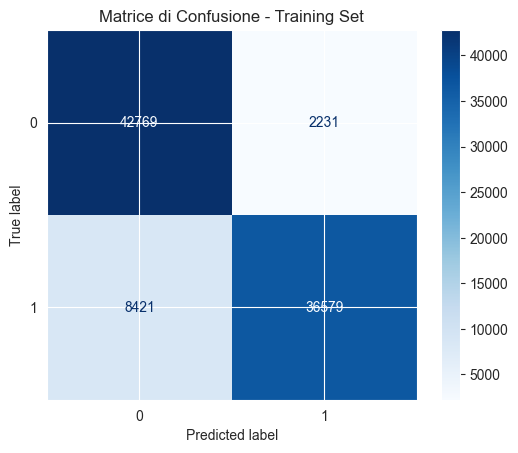

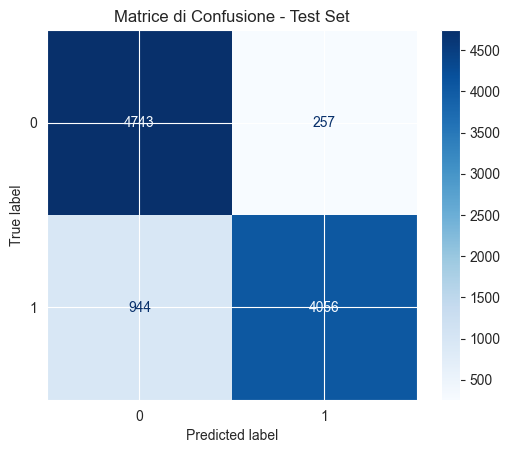

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_decision_tree_model.pkl"
    joblib.dump(model, filename)

# Inizializza il modello Decision Tree Classifier
model = DecisionTreeClassifier(
    criterion="gini",         # Funzione per misurare la qualità dello split ("gini" o "entropy")
    max_depth=None,           # Profondità massima dell'albero (None = nessun limite)
    min_samples_split=50,     # Minimo numero di campioni per suddividere un nodo
    random_state=42           
)

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_decision_tree"
os.makedirs(checkpoint_dir, exist_ok=True)

# Liste per memorizzare i punteggi di ciascun fold
train_fold_scores = []  # Accuratezza sul training set per ogni fold
test_fold_scores = []   # Accuratezza sul test set per ogni fold
best_accuracy = 0       # Per tenere traccia del miglior punteggio sul test set
best_model = None       # Per salvare il miglior modello

# Iterazione manuale per ciascun fold
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):  # Usa y per mantenere le proporzioni
    print(f"Fold {fold}/{kf.get_n_splits()}")
    
    # Suddividi il dataset in training e test per il fold corrente
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Addestra il modello sul training set
    model.fit(X_train, y_train)
    
    # Accuratezza sul training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_fold_scores.append(train_accuracy)
    print(f"Accuratezza sul training set (fold {fold}): {train_accuracy:.4f}")
    
    # Accuratezza sul test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_fold_scores.append(test_accuracy)
    print(f"Accuratezza sul test set (fold {fold}): {test_accuracy:.4f}")
    
    # Salva il modello se ha la miglior accuratezza sul test set finora
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        save_best_checkpoint(best_model)

# Calcola e stampa la media dei punteggi di tutti i fold
mean_train_accuracy = sum(train_fold_scores) / len(train_fold_scores)
mean_test_accuracy = sum(test_fold_scores) / len(test_fold_scores)

print("\nRisultati Finali:")
print(f"Accuratezza media sul training set: {mean_train_accuracy:.4f}")
print(f"Accuratezza media sul test set: {mean_test_accuracy:.4f}")

# Matrice di confusione sul training set per il miglior modello
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()


# Curva ROC Decision Tree

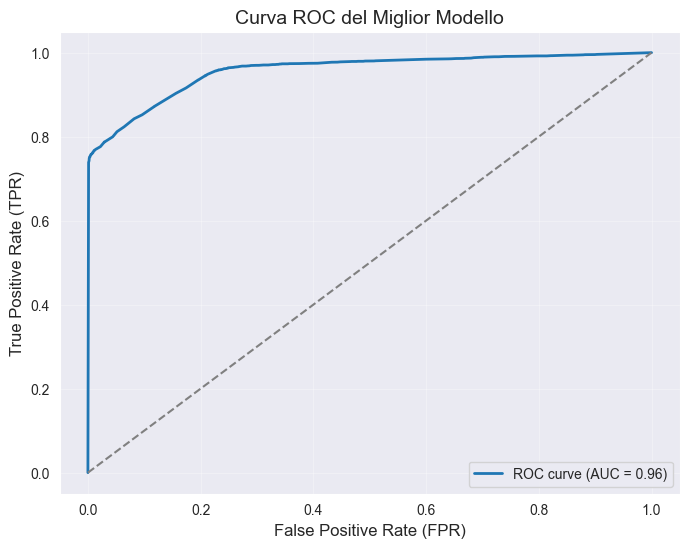

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcola le probabilità previste per la classe positiva
if hasattr(best_model, "predict_proba"):
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilità per la classe positiva
else:
    raise AttributeError("Il modello non supporta predict_proba, necessario per la curva ROC.")

# Calcola FPR, TPR e soglie per la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcola l'AUC (Area Under Curve)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Disegna la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=1.5)  # Linea diagonale
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.title("Curva ROC del Miglior Modello", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Random Forest Classifier

Fold 1/10
Accuratezza sul training set (fold 1): 0.9132
Accuratezza sul test set (fold 1): 0.9083
Fold 2/10
Accuratezza sul training set (fold 2): 0.9268
Accuratezza sul test set (fold 2): 0.9248
Fold 3/10
Accuratezza sul training set (fold 3): 0.9273
Accuratezza sul test set (fold 3): 0.9221
Fold 4/10
Accuratezza sul training set (fold 4): 0.9315
Accuratezza sul test set (fold 4): 0.9233
Fold 5/10
Accuratezza sul training set (fold 5): 0.9162
Accuratezza sul test set (fold 5): 0.9079
Fold 6/10
Accuratezza sul training set (fold 6): 0.9233
Accuratezza sul test set (fold 6): 0.9167
Fold 7/10
Accuratezza sul training set (fold 7): 0.9041
Accuratezza sul test set (fold 7): 0.8980
Fold 8/10
Accuratezza sul training set (fold 8): 0.9064
Accuratezza sul test set (fold 8): 0.8998
Fold 9/10
Accuratezza sul training set (fold 9): 0.9093
Accuratezza sul test set (fold 9): 0.9019
Fold 10/10
Accuratezza sul training set (fold 10): 0.9167
Accuratezza sul test set (fold 10): 0.9133

Risultati Finali

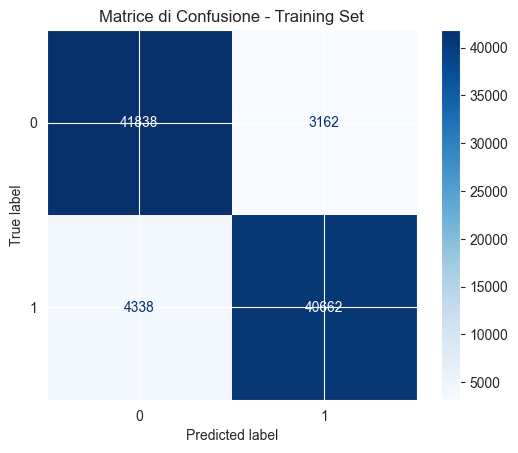

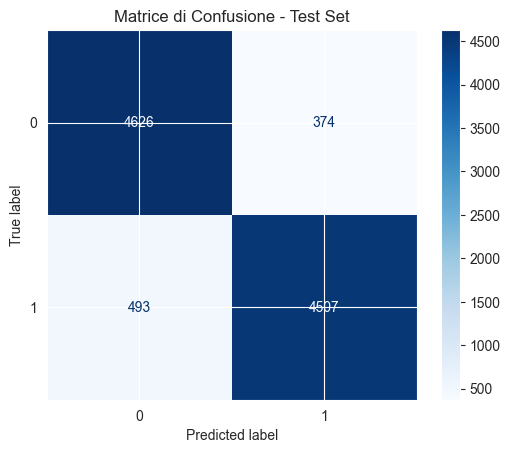

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_random_forest_model.pkl"
    joblib.dump(model, filename)

# Inizializza il modello
model = RandomForestClassifier(
    n_estimators=100,       # Numero di alberi
    max_depth=None,         # Profondità massima degli alberi
    min_samples_split=50,   # Minimo numero di campioni per suddividere un nodo
    random_state=42         
)

# Cartella per salvare i checkpoint
checkpoint_dir = "best_checkpoint_random_forest"
os.makedirs(checkpoint_dir, exist_ok=True)

# Configura Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Liste per memorizzare i punteggi di ciascun fold
train_fold_scores = []  # Accuratezza sul training set per ogni fold
test_fold_scores = []   # Accuratezza sul test set per ogni fold
best_accuracy = 0       # Per tenere traccia del miglior punteggio sul test set
best_model = None       # Per salvare il miglior modello

# Iterazione manuale per ciascun fold
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):  
    print(f"Fold {fold}/{kf.get_n_splits()}")

    # Suddividi il dataset in training e test per il fold corrente
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestra il modello sul training set
    model.fit(X_train, y_train)

    # Accuratezza sul training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_fold_scores.append(train_accuracy)
    print(f"Accuratezza sul training set (fold {fold}): {train_accuracy:.4f}")

    # Accuratezza sul test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_fold_scores.append(test_accuracy)
    print(f"Accuratezza sul test set (fold {fold}): {test_accuracy:.4f}")

    # Salva il modello se ha la miglior accuratezza sul test set finora
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        save_best_checkpoint(best_model)

# Calcola e stampa la media dei punteggi di tutti i fold
mean_train_accuracy = sum(train_fold_scores) / len(train_fold_scores)
mean_test_accuracy = sum(test_fold_scores) / len(test_fold_scores)

print("\nRisultati Finali:")
print(f"Accuratezza media sul training set: {mean_train_accuracy:.4f}")
print(f"Accuratezza media sul test set: {mean_test_accuracy:.4f}")

# Matrice di confusione sul training set per il miglior modello
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()

# Curva ROC Random Forest

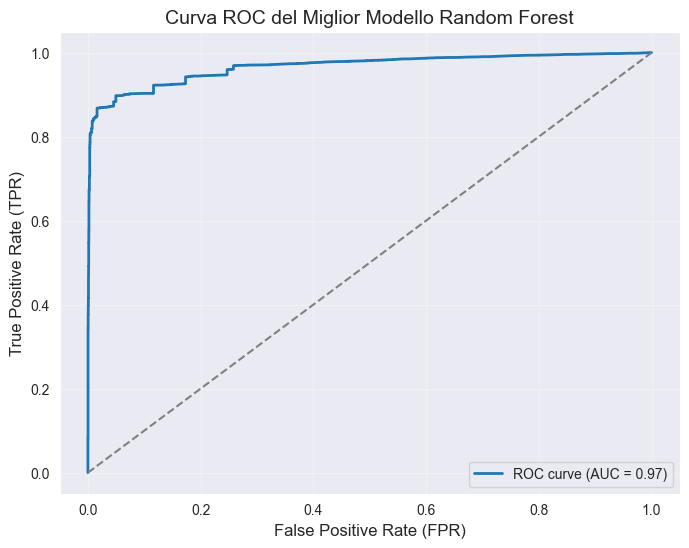

In [39]:
# Calcola le probabilità previste per la classe positiva
if hasattr(best_model, "predict_proba"):
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilità per la classe positiva
else:
    raise AttributeError("Il modello non supporta predict_proba, necessario per la curva ROC.")

# Calcola FPR, TPR e soglie per la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcola l'AUC (Area Under Curve)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Disegna la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=1.5)  # Linea diagonale
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.title("Curva ROC del Miglior Modello Random Forest", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Logistic Regression

Fold 1/10
Accuratezza sul training set (fold 1): 0.5178
Accuratezza sul test set (fold 1): 0.5255
Fold 2/10
Accuratezza sul training set (fold 2): 0.5179
Accuratezza sul test set (fold 2): 0.5246
Fold 3/10
Accuratezza sul training set (fold 3): 0.5187
Accuratezza sul test set (fold 3): 0.5175
Fold 4/10
Accuratezza sul training set (fold 4): 0.5188
Accuratezza sul test set (fold 4): 0.5160
Fold 5/10
Accuratezza sul training set (fold 5): 0.5185
Accuratezza sul test set (fold 5): 0.5190
Fold 6/10
Accuratezza sul training set (fold 6): 0.5194
Accuratezza sul test set (fold 6): 0.5106
Fold 7/10
Accuratezza sul training set (fold 7): 0.5192
Accuratezza sul test set (fold 7): 0.5125
Fold 8/10
Accuratezza sul training set (fold 8): 0.5190
Accuratezza sul test set (fold 8): 0.5143
Fold 9/10
Accuratezza sul training set (fold 9): 0.5179
Accuratezza sul test set (fold 9): 0.5248
Fold 10/10
Accuratezza sul training set (fold 10): 0.5183
Accuratezza sul test set (fold 10): 0.5207

Risultati Finali

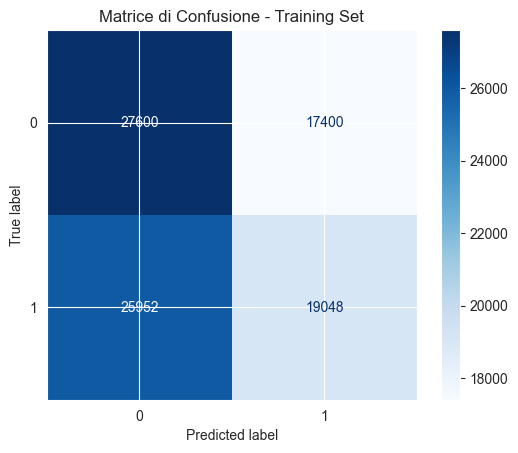

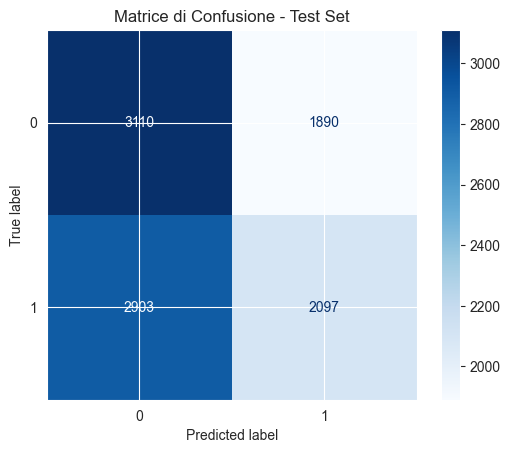

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_logistic_regression_model.pkl"
    joblib.dump(model, filename)

# Inizializza il modello Logistic Regression
model = LogisticRegression(
    penalty='elasticnet',          # Regolarizzazione L2
    C= 0.1,                 # Inverso della forza di regolarizzazione
    solver='saga',        # Solutore per problemi grandi
    l1_ratio=0.5,
    max_iter=1000,         # Iterazioni massime
    random_state=42        # Per riproducibilità
)

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_logistic_regression"
os.makedirs(checkpoint_dir, exist_ok=True)

# Liste per memorizzare i punteggi di ciascun fold
train_fold_scores = []  # Accuratezza sul training set per ogni fold
test_fold_scores = []   # Accuratezza sul test set per ogni fold
best_accuracy = 0       # Per tenere traccia del miglior punteggio sul test set
best_model = None       # Per salvare il miglior modello

# Iterazione manuale per ciascun fold
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    print(f"Fold {fold}/{kf.get_n_splits()}")

    # Suddividi il dataset in training e test per il fold corrente
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestra il modello sul training set
    model.fit(X_train, y_train)

    # Accuratezza sul training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_fold_scores.append(train_accuracy)
    print(f"Accuratezza sul training set (fold {fold}): {train_accuracy:.4f}")

    # Accuratezza sul test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_fold_scores.append(test_accuracy)
    print(f"Accuratezza sul test set (fold {fold}): {test_accuracy:.4f}")

    # Salva il modello se ha la miglior accuratezza sul test set finora
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        save_best_checkpoint(best_model)

# Calcola e stampa la media dei punteggi di tutti i fold
mean_train_accuracy = sum(train_fold_scores) / len(train_fold_scores)
mean_test_accuracy = sum(test_fold_scores) / len(test_fold_scores)

print("\nRisultati Finali:")
print(f"Accuratezza media sul training set: {mean_train_accuracy:.4f}")
print(f"Accuratezza media sul test set: {mean_test_accuracy:.4f}")

# Matrice di confusione sul training set per il miglior modello
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()


# Curva ROC per Logistic Regression

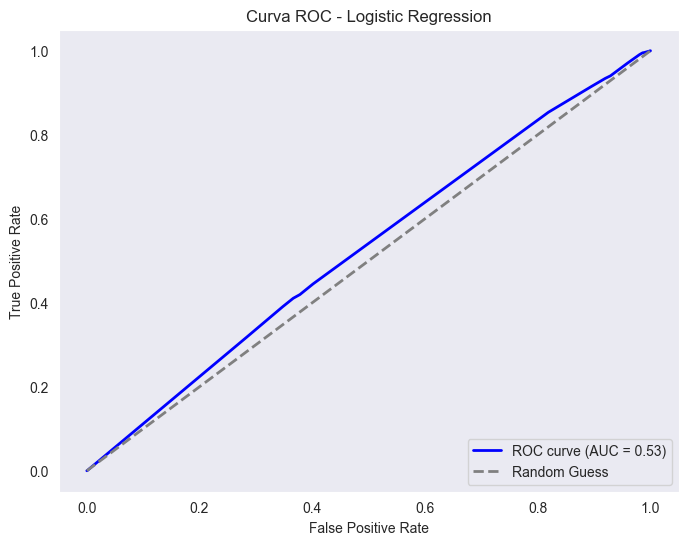

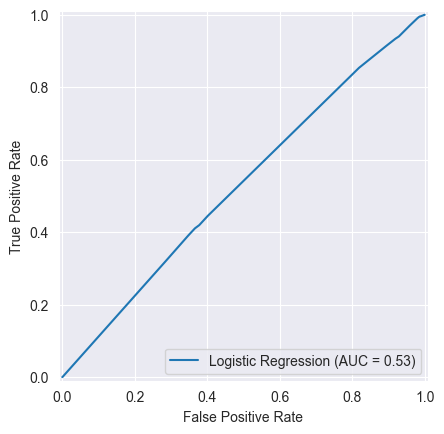

In [41]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Calcola le probabilità predette per la classe positiva (1)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilità per la classe positiva

# Calcola i valori FPR (False Positive Rate), TPR (True Positive Rate) e le soglie
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcola l'AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Visualizza la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# In alternativa, puoi usare RocCurveDisplay
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Logistic Regression")
roc_display.plot()
plt.show()

# Hyperparameter Ottimization: GridSearch()

# Decision Tree

Fitting 10 folds for each of 24 candidates, totalling 240 fits

Migliori parametri trovati:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}
Accuratezza media del miglior modello: 0.8743
Miglior modello salvato: best_checkpoint_decision_tree/best_decision_tree_model.pkl


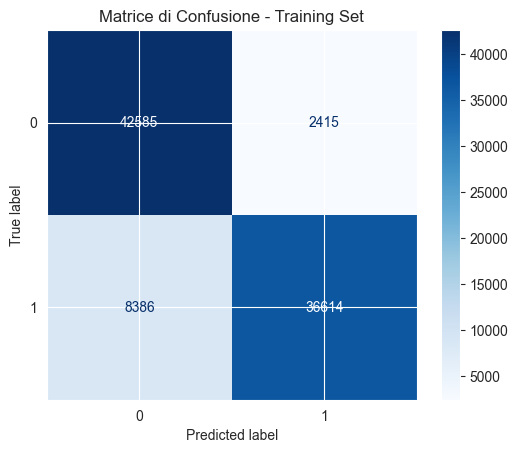

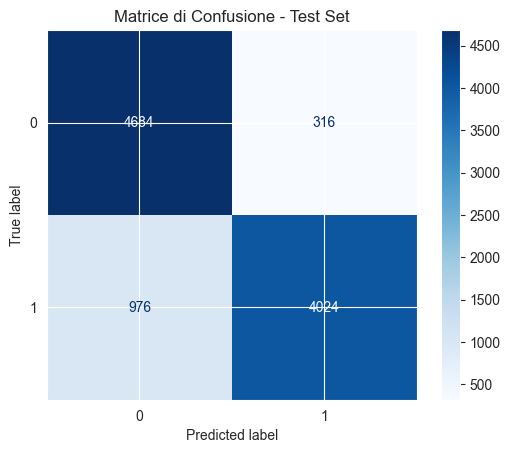

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_decision_tree_model.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_decision_tree"
os.makedirs(checkpoint_dir, exist_ok=True)

# Configura Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definizione dei parametri per il Grid Search
param_grid = {
    "criterion": ["gini", "entropy"],  # Funzione per misurare la qualità dello split
    "max_depth": [None, 10, 20, 30],  # Profondità massima dell'albero
    "min_samples_split": [10, 20, 50]  # Minimo numero di campioni per suddividere un nodo
}

# Inizializza il modello Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

# Configura il Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,                # Usa StratifiedKFold come validazione incrociata
    scoring="accuracy",   # Metrica da ottimizzare
    n_jobs=-1,            # Usa tutti i processori disponibili
    verbose=2             # Stampa il progresso
)

# Esegui il Grid Search con i dati bilanciati
grid_search.fit(X, y)

# Migliori parametri trovati
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuratezza media del miglior modello: {grid_search.best_score_:.4f}")

# Salva il miglior modello come checkpoint
best_model = grid_search.best_estimator_
save_best_checkpoint(best_model)

# Matrice di confusione sul training set per il miglior modello
train_index, test_index = next(iter(kf.split(X, y)))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

best_model.fit(X_train, y_train)
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()



# Random Forest

Fitting 10 folds for each of 27 candidates, totalling 270 fits

Migliori parametri trovati:
{'max_depth': None, 'min_samples_split': 20, 'n_estimators': 200}
Accuratezza media del miglior modello: 0.9261
Miglior modello salvato: best_checkpoint_random_forest/best_random_forest_model.pkl


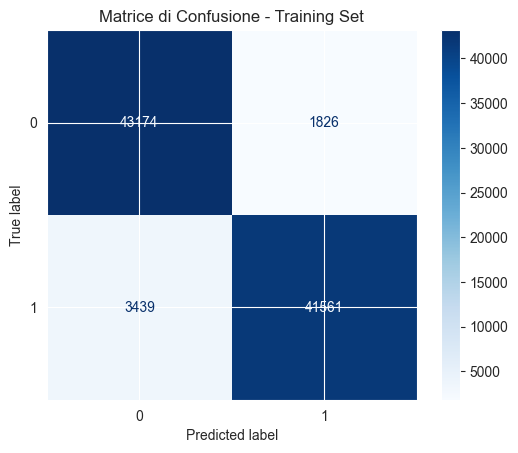

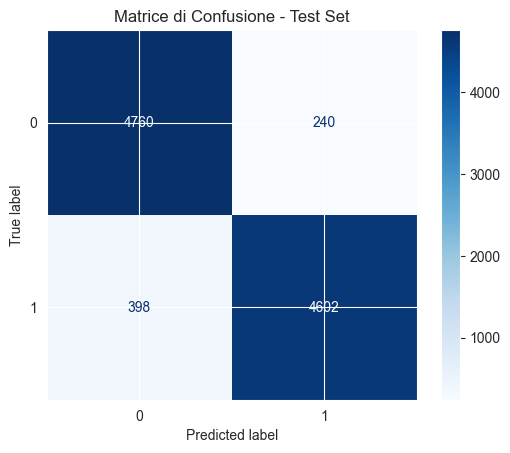

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_random_forest_model.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_random_forest"
os.makedirs(checkpoint_dir, exist_ok=True)

# Configura Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definizione dei parametri per il Grid Search
param_grid = {
    "n_estimators": [50, 100, 200],       # Numero di alberi nella foresta
    "max_depth": [None, 10, 20],          # Profondità massima
    "min_samples_split": [2, 10, 20]     # Minimo numero di campioni per suddividere un nodo
}

# Inizializza il modello Random Forest
model = RandomForestClassifier(random_state=42)

# Configura il Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,                # Usa StratifiedKFold come validazione incrociata
    scoring="accuracy",   # Metrica da ottimizzare
    n_jobs=-1,            # Usa tutti i processori disponibili
    verbose=2             # Stampa il progresso
)

# Esegui il Grid Search con i dati bilanciati
grid_search.fit(X, y)

# Migliori parametri trovati
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuratezza media del miglior modello: {grid_search.best_score_:.4f}")

# Salva il miglior modello come checkpoint
best_model = grid_search.best_estimator_
save_best_checkpoint(best_model)

# Calcolo della matrice di confusione sul miglior modello
train_index, test_index = next(iter(kf.split(X, y)))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Addestra il miglior modello trovato con Grid Search
best_model.fit(X_train, y_train)

# Matrice di confusione sul training set
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()

# Logistic Regression

Fitting 10 folds for each of 24 candidates, totalling 240 fits

Migliori parametri trovati:
{'C': 10, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}
Accuratezza media del miglior modello: 0.5256
Miglior modello salvato: best_checkpoint_logistic_regression/best_logistic_regression_model.pkl


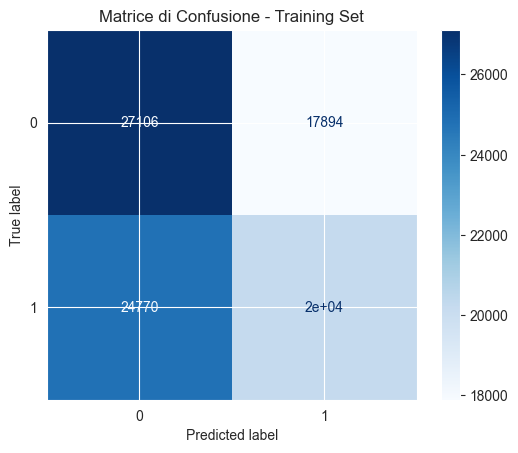

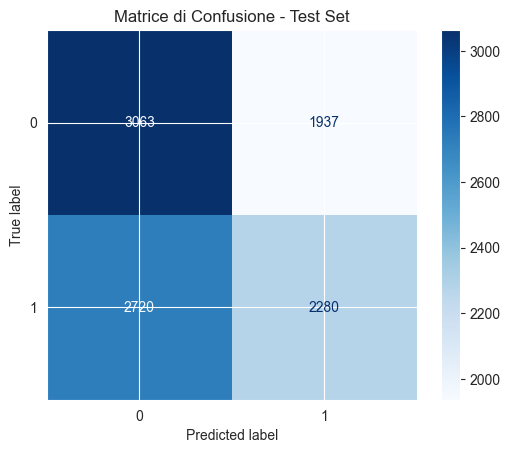

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import os
import joblib
import matplotlib.pyplot as plt

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_logistic_regression_model.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_logistic_regression"
os.makedirs(checkpoint_dir, exist_ok=True)

# Definizione dei parametri per il Grid Search
param_grid = [
    {"penalty": ["l1"], "C": [0.01, 0.1, 1, 10], "solver": ["saga"], "max_iter": [2000]},
    {"penalty": ["l2"], "C": [0.01, 0.1, 1, 10], "solver": ["saga", "lbfgs"], "max_iter": [2000]},
    {"penalty": ["elasticnet"], "C": [0.01, 0.1, 1, 10], "solver": ["saga"], "l1_ratio": [0.1, 0.5, 0.9], "max_iter": [2000]}
]

# Inizializza il modello Logistic Regression
model = LogisticRegression(random_state=42)

# Configura il Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,                # Usa StratifiedKFold come validazione incrociata
    scoring="accuracy",   # Metrica da ottimizzare
    n_jobs=-1,            # Usa tutti i processori disponibili
    verbose=2             # Stampa il progresso
)

# Esegui il Grid Search con i dati bilanciati
grid_search.fit(X, y)

# Migliori parametri trovati
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuratezza media del miglior modello: {grid_search.best_score_:.4f}")

# Salva il miglior modello come checkpoint
best_model = grid_search.best_estimator_
save_best_checkpoint(best_model)

# Matrice di confusione sul training set per il miglior modello
train_index, test_index = next(iter(kf.split(X, y)))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

best_model.fit(X_train, y_train)
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()

# La Logistic Regression è un modello di classificazione semplice. Motivi per cui potrebbe non essere adeguata:
# I dati potrebbero essero non linearmente separabili
# Troppe feature